In [186]:
import pandas as pd
import numpy as np
import seaborn as sns
import lazypredict
import sklearn
import xgboost
import lightgbm
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from lazypredict.Supervised import LazyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score 
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2, RFECV
from scipy.stats import chi2_contingency 


In [117]:
data_url = ("/Users/vidyakumar/Desktop/python/apziva/term-deposit-marketing-2020.csv")

In [118]:
def load_data():
    data = pd.read_csv(data_url)
    return data

data = load_data()

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [119]:
data['day'].value_counts()

20    2655
18    2173
21    1914
17    1812
6     1778
5     1691
19    1650
28    1650
14    1636
8     1620
7     1612
29    1600
15    1468
30    1457
9     1374
13    1325
12    1289
11    1272
16    1215
4     1183
2     1109
27     974
26     895
3      874
23     823
22     773
25     695
31     591
10     364
24     352
1      176
Name: day, dtype: int64

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [121]:
data_job = pd.get_dummies(data['job'], prefix = 'job', prefix_sep = '_', drop_first = True)
data_marital = pd.get_dummies(data['marital'], prefix = 'marital', prefix_sep = '_', drop_first = True)
data_education = pd.get_dummies(data['education'], prefix = 'education', prefix_sep = '_', drop_first = True)
data_default = pd.get_dummies(data['default'], prefix = 'default', prefix_sep = '_', drop_first = True)
data_housing = pd.get_dummies(data['housing'], prefix = 'housing', prefix_sep = '_', drop_first = True)
data_loan = pd.get_dummies(data['loan'], prefix = 'loan', prefix_sep = '_', drop_first = True)
data_contact = pd.get_dummies(data['contact'], prefix = 'contact', prefix_sep = '_', drop_first = True)
data_month = pd.get_dummies(data['month'], prefix = 'month', prefix_sep = '_', drop_first = True)
data_y = pd.get_dummies(data['y'], prefix = 'y', prefix_sep = '_', drop_first = True)

In [122]:
# Concat original data frame and dummy columns
data_dc = data.drop(columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y'])
data_dc = pd.concat([data_dc, data_job, data_marital, data_education, data_default, data_housing, data_loan, data_contact, data_month, data_y], axis = 1)

In [123]:
data_dc.describe()

,age,balance,day,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,y_yes
count,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,...,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00
mean,40.54,1274.28,16.02,254.82,2.88,0.23,0.04,0.03,0.20,0.04,...,0.00,0.06,0.03,0.16,0.12,0.01,0.34,0.09,0.00,0.07
std,9.64,2903.77,8.28,259.37,3.24,0.42,0.18,0.16,0.40,0.19,...,0.02,0.23,0.17,0.37,0.32,0.08,0.47,0.29,0.04,0.26
min,19.00,-8019.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,33.00,54.00,8.00,100.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,39.00,407.00,17.00,175.00,2.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,48.00,1319.00,21.00,313.00,3.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
max,95.00,102127.00,31.00,4918.00,63.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [124]:
from sklearn.preprocessing import MinMaxScaler 
minmaxscaler = MinMaxScaler(feature_range=(5, 10)) 
minmaxscaler.fit(data_dc[['age']]) 
data_dc['scaled_age'] = minmaxscaler.transform(data_dc[['age']]) 
data_dc['scaled_age'].describe()

count   40000.00
mean        6.42
std         0.63
min         5.00
25%         5.92
50%         6.32
75%         6.91
max        10.00
Name: scaled_age, dtype: float64

In [125]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

data_dc['scaled_balance'] = scaler.fit_transform(data_dc[['balance']])
data_dc['scaled_balance'].describe()


count   40000.00
mean        0.01
std         0.03
min        -0.08
25%         0.00
50%         0.00
75%         0.01
max         1.00
Name: scaled_balance, dtype: float64

In [126]:
data_dc['duration'].mean()
data_dc['avg_zscore_duration'] = (data_dc['duration'] - data_dc['duration'].mean())/data_dc['duration'].std(ddof=0)

In [127]:
cut_labels = ['early_month', 'mid_month', 'end_month']
cut_bins = [1, 11, 21, 31]
data_dc['day_cut'] = pd.cut(data_dc['day'], bins=cut_bins, labels=cut_labels)
data_dc.head()

,age,balance,day,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_jun,month_mar,month_may,month_nov,month_oct,y_yes,scaled_age,scaled_balance,avg_zscore_duration,day_cut
0,58,2143,5,261,1,0,0,0,1,0,...,0,0,1,0,0,0,7.57,0.02,0.02,early_month
1,44,29,5,151,1,0,0,0,0,0,...,0,0,1,0,0,0,6.64,0.00,-0.40,early_month
2,33,2,5,76,1,0,1,0,0,0,...,0,0,1,0,0,0,5.92,0.00,-0.69,early_month
3,47,1506,5,92,1,1,0,0,0,0,...,0,0,1,0,0,0,6.84,0.01,-0.63,early_month
4,33,1,5,198,1,0,0,0,0,0,...,0,0,1,0,0,0,5.92,0.00,-0.22,early_month


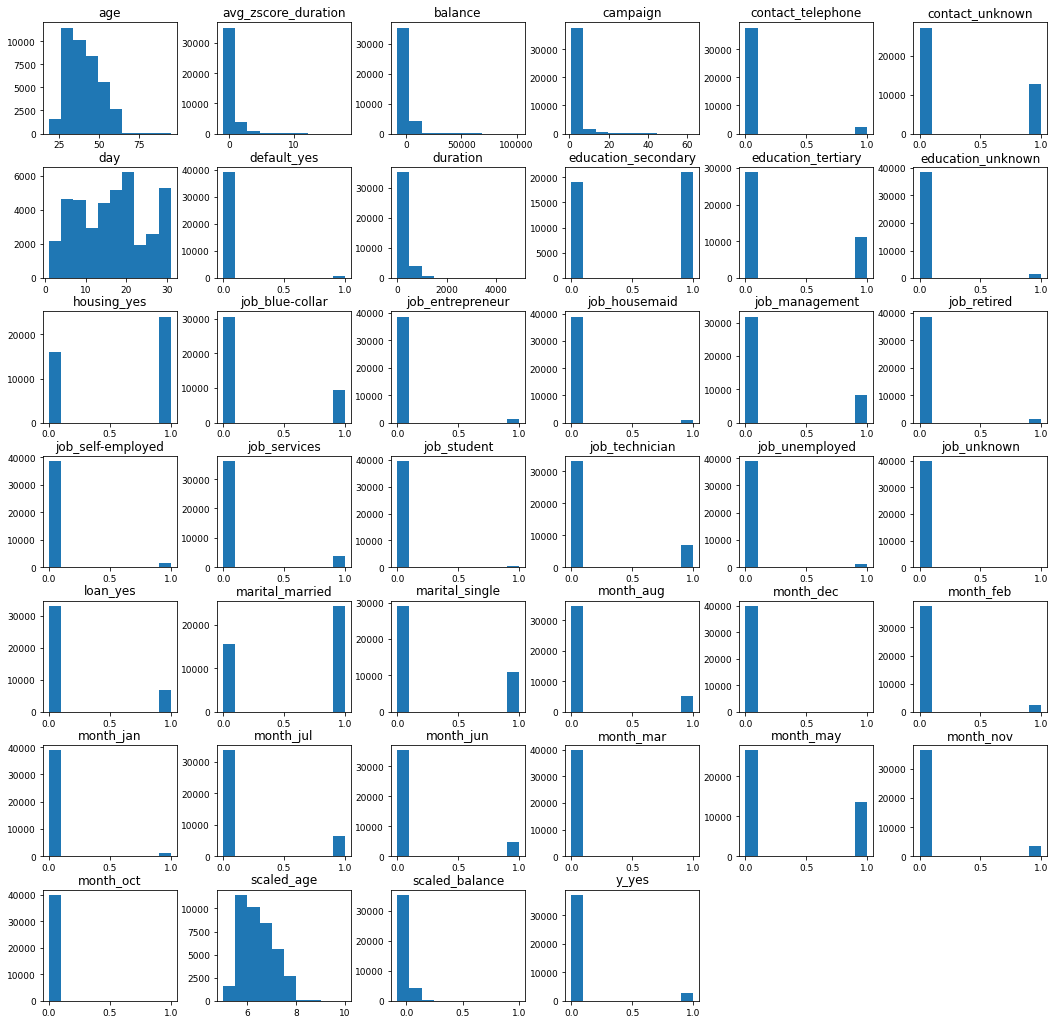

In [128]:
# Visualize numerical features using histogram
data_dc.hist(figsize = (18,18), grid = False, xlabelsize=9, ylabelsize=9)
plt.show()

In [ ]:
# ->Call volume peaks in the month of May, Married people - Majority of call volume

In [129]:
data_dc.describe()

,age,balance,day,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,y_yes,scaled_age,scaled_balance,avg_zscore_duration
count,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,...,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00
mean,40.54,1274.28,16.02,254.82,2.88,0.23,0.04,0.03,0.20,0.04,...,0.16,0.12,0.01,0.34,0.09,0.00,0.07,6.42,0.01,0.00
std,9.64,2903.77,8.28,259.37,3.24,0.42,0.18,0.16,0.40,0.19,...,0.37,0.32,0.08,0.47,0.29,0.04,0.26,0.63,0.03,1.00
min,19.00,-8019.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,-0.08,-0.98
25%,33.00,54.00,8.00,100.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.92,0.00,-0.60
50%,39.00,407.00,17.00,175.00,2.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.32,0.00,-0.31
75%,48.00,1319.00,21.00,313.00,3.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,6.91,0.01,0.22
max,95.00,102127.00,31.00,4918.00,63.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,10.00,1.00,17.98


In [130]:
#checking if its balanced dataset -- imbalanced dataset
data_dc['y_yes'].value_counts()

0    37104
1     2896
Name: y_yes, dtype: int64

In [131]:
X = data_dc.drop(columns = ['y_yes'])
y = data_dc['y_yes']


In [79]:
rs=12
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rs)
print(X_train.shape)           
print(X_test.shape)

(32000, 37)
(8000, 37)


In [132]:
#random oversampling
ros = RandomOverSampler(random_state = rs)     
X_ros, y_ros = ros.fit_resample(X_train, y_train) 

In [133]:
pd.value_counts(y_ros) 

1    29692
0    29692
Name: y_yes, dtype: int64

In [134]:
#logistic regression - ros
logisticRegr = LogisticRegression()
lr = logisticRegr.fit(X_ros, y_ros)
y_pred=logisticRegr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.87      0.92      7412
           1       0.34      0.86      0.49       588

    accuracy                           0.87      8000
   macro avg       0.66      0.86      0.71      8000
weighted avg       0.94      0.87      0.89      8000



In [135]:
# predict probabilities 
y_prob=logisticRegr.predict_proba(X_test)
print(y_prob)

[[0.35158151 0.64841849]
 [0.00618807 0.99381193]
 [0.83684748 0.16315252]
 ...
 [0.85381521 0.14618479]
 [0.97080767 0.02919233]
 [0.95045411 0.04954589]]


In [136]:
# keep probabilities for the positive outcome only
probs = y_prob[:, 1]

In [137]:
# calculate roc auc
auc = roc_auc_score(y_test, probs)
print(auc)

0.9258926047483214


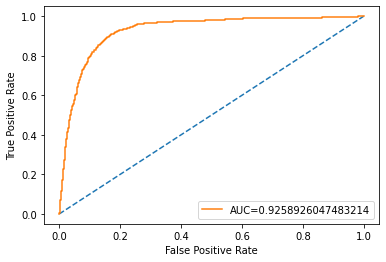

In [138]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
# show the plot
plt.show()

In [139]:
cross_val_score(logisticRegr, X_ros, y_ros, cv=5)

array([0.86604361, 0.86275996, 0.86435969, 0.86537004, 0.86375884])

In [140]:
#smote balancing
smo = SMOTE(random_state = rs)                      # Create an instance of SMOTE
X_smo, y_smo = smo.fit_resample(X_train, y_train)           # Resample the training data

In [141]:
pd.value_counts(y_smo)                                      # Get counts after class balancing

1    29692
0    29692
Name: y_yes, dtype: int64

In [142]:
#logistic regression - smote
logisticRegr = LogisticRegression()
lr_smo = logisticRegr.fit(X_smo, y_smo)
y_pred_smo=logisticRegr.predict(X_test)
print(classification_report(y_test, y_pred_smo))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      7412
           1       0.39      0.64      0.49       588

    accuracy                           0.90      8000
   macro avg       0.68      0.78      0.72      8000
weighted avg       0.93      0.90      0.91      8000



In [143]:
# predict probabilities 
y_prob_smo=logisticRegr.predict_proba(X_test)
print(y_prob_smo)

[[0.43255715 0.56744285]
 [0.02223238 0.97776762]
 [0.95795179 0.04204821]
 ...
 [0.99484877 0.00515123]
 [0.99473236 0.00526764]
 [0.99520315 0.00479685]]


In [144]:
# keep probabilities for the positive outcome only
probs = y_prob_smo[:, 1]

In [145]:
# calculate roc auc
auc = roc_auc_score(y_test, probs)
print(auc)

0.8967717821073384


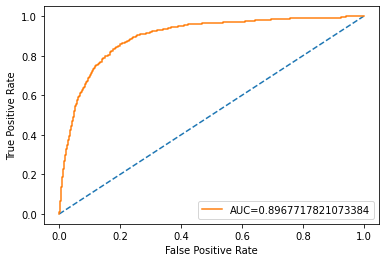

In [146]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
# show the plot
plt.show()

In [147]:
cross_val_score(logisticRegr, X_smo, y_smo, cv=5) 

array([0.86351772, 0.94047318, 0.94426202, 0.94628273, 0.94333109])

In [155]:
#random undersampling
rus = RandomUnderSampler(random_state = rs)               # Create an instance of RandomUnderSampler
X_rus, y_rus = rus.fit_resample(X_train, y_train)                 # Resample training data

In [156]:
pd.value_counts(y_rus)

1    2308
0    2308
Name: y_yes, dtype: int64

In [157]:
#logistic regression - rus
logisticRegr = LogisticRegression()
lr_rus = logisticRegr.fit(X_rus, y_rus)
y_pred_rus=logisticRegr.predict(X_test)
print(classification_report(y_test, y_pred_rus))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      7412
           1       0.35      0.86      0.49       588

    accuracy                           0.87      8000
   macro avg       0.67      0.87      0.71      8000
weighted avg       0.94      0.87      0.89      8000



In [158]:
# predict probabilities 
y_prob_rus=logisticRegr.predict_proba(X_test)
probs = y_prob_rus[:, 1]

In [159]:
auc = roc_auc_score(y_test, probs)
print(auc)

0.9256948192120886


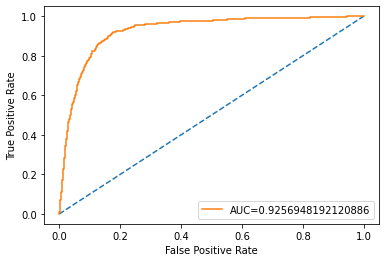

In [153]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
# show the plot
plt.show()

In [154]:
cross_val_score(logisticRegr, X_rus, y_rus, cv=5) 

array([0.86580087, 0.86348862, 0.86132178, 0.84832069, 0.83748646])

In [38]:
#Random undersampling and randomoversampling produce best results

In [160]:
#knn classifier - ros
k_range = range(1,50)                                
scores = {}                                          
score_list = []                                     
for k in k_range:                                    
    knn = KNeighborsClassifier(n_neighbors = k)     
    knn.fit(X_ros, y_ros)                        
    y_pred_knn = knn.predict(X_test)                 
    scores[k] = f1_score(y_test, y_pred_knn)         
    score_list.append(f1_score(y_test, y_pred_knn))  


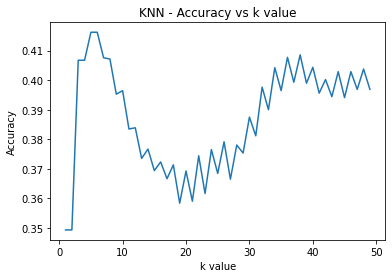

In [161]:
#identifying k value for best accuracy
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, score_list)                   
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN - Accuracy vs k value')
plt.show()

In [162]:
print(max(score_list))
print(max(scores, key=scores.get))

0.41620626151012885
5


In [163]:
#building the final knn model with k=10
knnc = KNeighborsClassifier(n_neighbors = 5)     
knf = knnc.fit(X_ros, y_ros)                        
y_pred_knn = knnc.predict(X_test) 
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      7412
           1       0.33      0.58      0.42       588

    accuracy                           0.88      8000
   macro avg       0.64      0.74      0.68      8000
weighted avg       0.92      0.88      0.90      8000



In [164]:
#SVC - rus
svc = SVC()                                                     # Create an instance of SVC
svc.fit(X_rus, y_rus)                                           # Fit model with SMOTE oversampled training data
print(classification_report(y_test, svc.predict(X_test)))       # Generate classification report

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      7412
           1       0.34      0.70      0.46       588

    accuracy                           0.88      8000
   macro avg       0.66      0.80      0.70      8000
weighted avg       0.93      0.88      0.90      8000



In [165]:
cross_val_score(svc, X_rus, y_rus, cv=5)

array([0.81818182, 0.81473456, 0.81581798, 0.79414951, 0.79848321])

In [166]:
#Xgbc - rus
xgbc = XGBClassifier()
xgbc.fit(X_rus, y_rus)
print(classification_report(y_test, xgbc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7412
           1       0.34      0.90      0.49       588

    accuracy                           0.86      8000
   macro avg       0.66      0.88      0.71      8000
weighted avg       0.94      0.86      0.89      8000



In [167]:
cross_val_score(xgbc, X_rus, y_rus, cv=5)

array([0.88852814, 0.86890574, 0.88840737, 0.86890574, 0.86132178])

In [169]:
#lgbm - ros
lgbm = LGBMClassifier()                                         # Create an instance of LGBMClassifier
lgbm.fit(X_ros, y_ros)                                          # Fit model with SMOTE oversampled training data
print(classification_report(y_test, lgbm.predict(X_test)))      # Generate classification report

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      7412
           1       0.37      0.89      0.53       588

    accuracy                           0.88      8000
   macro avg       0.68      0.89      0.73      8000
weighted avg       0.95      0.88      0.90      8000



In [170]:
cross_val_score(lgbm, X_ros, y_ros, cv=5)

array([0.92826471, 0.92986444, 0.92876989, 0.9261598 , 0.92910071])

In [172]:
#RFC - rus
rfc = RandomForestClassifier(n_jobs=2, random_state=rs)
rfc.fit(X_rus, y_rus)
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7412
           1       0.33      0.89      0.48       588

    accuracy                           0.86      8000
   macro avg       0.66      0.87      0.70      8000
weighted avg       0.94      0.86      0.89      8000



In [173]:
#lgbm - rus
lgbm = LGBMClassifier()                                         
lgbm.fit(X_rus, y_rus)                                          
print(classification_report(y_test, lgbm.predict(X_test)))    

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7412
           1       0.33      0.91      0.49       588

    accuracy                           0.86      8000
   macro avg       0.66      0.88      0.70      8000
weighted avg       0.94      0.86      0.89      8000



In [174]:
cross_val_score(lgbm, X_rus, y_rus, cv=5)

array([0.88852814, 0.88624052, 0.88299025, 0.86890574, 0.87323944])

In [177]:
gridParams = {
    'learning_rate': [0.02,0.04],
    'n_estimators': [6,8,16],
    'num_leaves': [16,18,20,22], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['binary'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    'colsample_bytree' : [0.62, 0.64, 0.65],
    'subsample' : [0.65,0.7],
    'reg_alpha' : [1.2,1.4],
    'reg_lambda' : [0.6,0.8,1],
    }


In [178]:
grid = GridSearchCV(lgbm, gridParams, verbose=1, cv=5, n_jobs=-1, scoring='recall')
# Run the grid
grid.fit(X_rus, y_rus)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 712 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1712 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 3112 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 4912 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 7112 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 9712 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 12712 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 16112 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 17273 out of 17280 | elapsed:  5.8min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 17280 out of 17280 | elapsed:  5.8min finished


{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.02, 'max_bin': 510, 'n_estimators': 8, 'num_leaves': 20, 'objective': 'binary', 'random_state': 500, 'reg_alpha': 1.2, 'reg_lambda': 0.8, 'subsample': 0.65}
0.8778244170868901


In [ ]:
#Based on the modeling so far, we see that LGBM model gives the highest recall for class 1 at 91%.


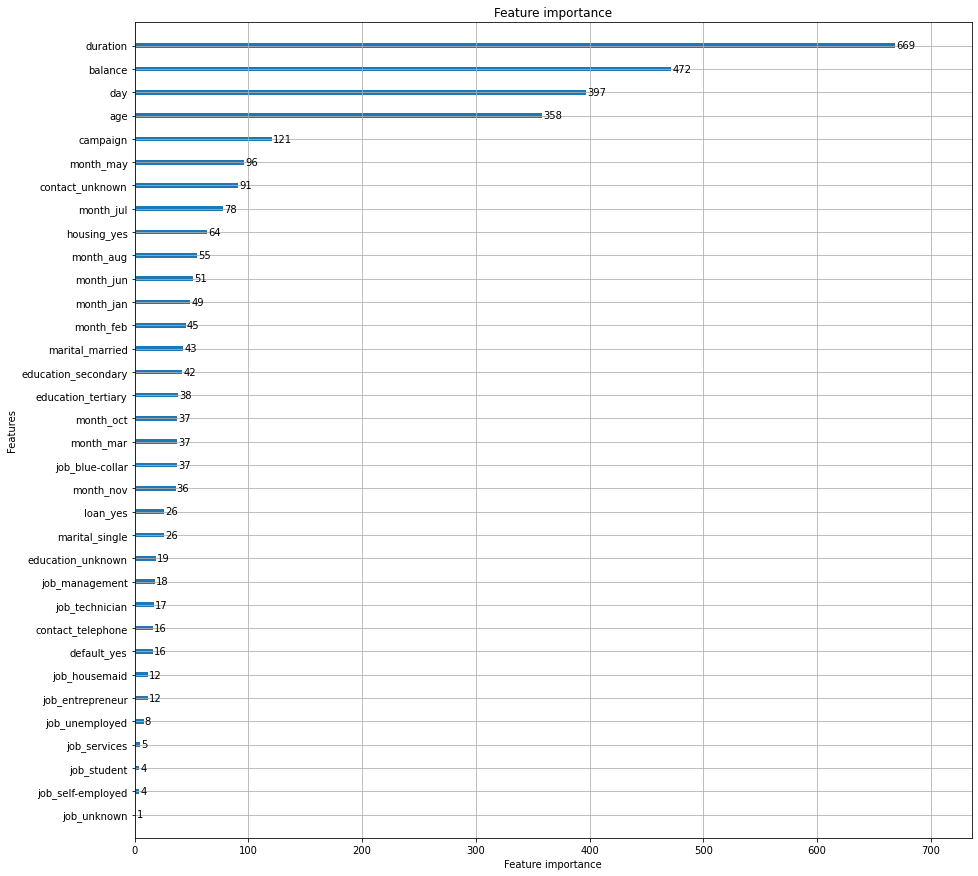

In [180]:
ax = lightgbm.plot_importance(lgbm, max_num_features=40, figsize=(15,15))
plt.show()

In [189]:
rfecv = RFECV(estimator = rfc, step = 1, cv = StratifiedKFold(10), scoring = 'recall')  # Creating an instance of RFECV usin Random Forest as estimator
rfecv.fit(X_rus,y_rus)                                                                                   # Fitting data into rfecv


RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(n_jobs=2, random_state=12),
      scoring='recall')

In [190]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 34


In [191]:
rfecv.estimator.feature_importances_

array([5.79848164e-02, 8.01564907e-02, 6.99932559e-02, 4.49852939e-01,
       3.50786542e-02, 9.38882967e-03, 3.36327918e-03, 2.45690750e-03,
       8.13269388e-03, 2.74591963e-03, 2.66872430e-03, 5.71167600e-03,
       2.53291854e-03, 8.61133386e-03, 3.44343745e-03, 1.09958348e-03,
       1.01174073e-02, 7.81289429e-03, 1.00350799e-02, 1.04694233e-02,
       4.20302484e-03, 1.71597258e-03, 1.84725603e-02, 8.91175552e-03,
       5.64751480e-03, 2.84580527e-02, 1.21359722e-02, 9.14184368e-05,
       9.72286829e-03, 6.24713632e-03, 1.60656765e-02, 8.40384040e-03,
       1.37086041e-02, 1.23783532e-02, 7.90604292e-03, 8.03395119e-03,
       5.62409909e-02])

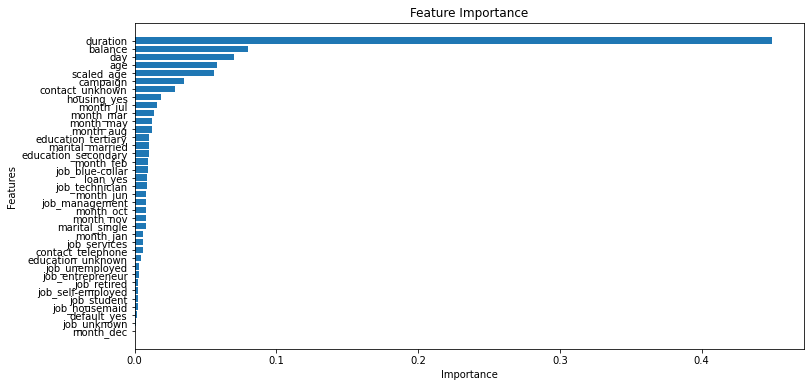

In [209]:
sorted_idx = rfecv.estimator.feature_importances_.argsort()                          # Order features based on importance
plt.barh(X.columns[sorted_idx], rfecv.estimator.feature_importances_[sorted_idx])   # Plot bar graph
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

In [ ]:
#From the above feature importance, we see that duration and balance are most positively influential parameters

In [205]:
#PCA
col_list = data_dc.drop("day_cut", axis='columns')
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(col_list)
col_list.shape

(40000, 40)

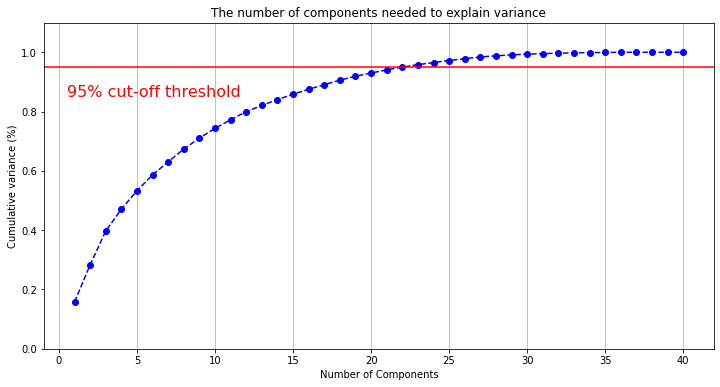

In [207]:
pca = PCA().fit(data_rescaled)

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 41, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [ ]:
#In this case, to get 95% of variance explained I need 22 principal components.